In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.inspection import plot_partial_dependence

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data 9

In [2]:
# Read in
df9 = pd.read_csv('../data/df9.csv')

In [3]:
# Inspect
df9.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-1.912877,-0.509738,1.935923,-2.119992,0.474137,3.647543,A2,B2,C33,D3,-23.858957
1,-0.341252,0.341502,2.268666,-0.948835,-0.492523,4.159113,A1,B4,C32,D2,4.795576
2,0.658157,-0.347933,3.104409,0.236928,0.359240,6.498557,A1,B4,C4,D2,16.359090
3,2.288540,-1.028834,3.554489,-0.215137,-0.436760,7.154874,A2,B1,C11,D3,-24.550723
4,0.618358,-1.526877,3.857197,-0.343902,0.098206,7.857794,A2,B2,C12,D3,-23.033020


In [4]:
df9.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
995,-0.377935,-0.810448,3.658649,0.614948,-1.292935,7.227878,A1,B1,C13,D3,14.729703
996,0.968435,1.273159,3.449217,-0.073787,1.088958,6.701653,A1,B4,C42,D2,5.337900
997,0.919181,-1.518937,3.427333,1.152154,0.039267,6.797440,A2,B1,C22,D3,-8.781643
998,0.248702,-0.184816,2.923806,1.188720,-0.361918,6.040283,A2,B5,C11,D2,-15.494192
999,0.937344,-1.455486,4.277617,-0.350077,1.197847,8.533164,A1,B1,C37,D3,-3.665508


### First, summarize each variable

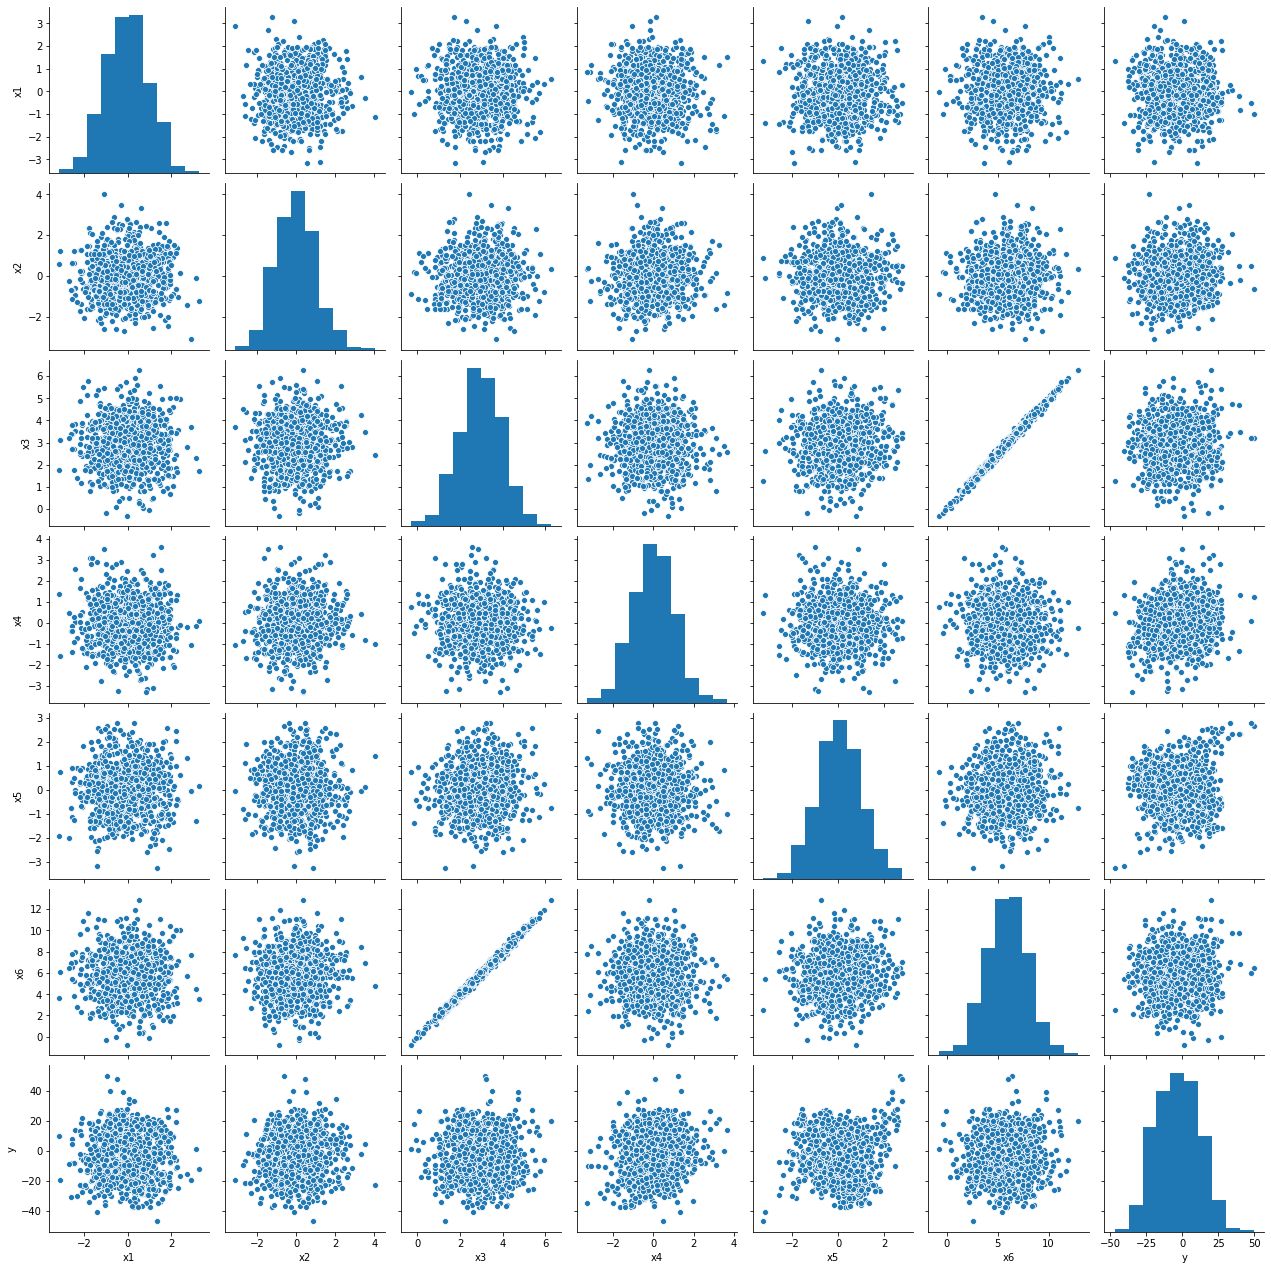

In [5]:
# Numerics
sb.pairplot(df9)

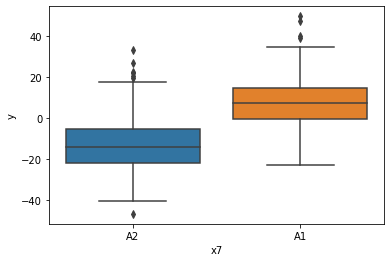

In [6]:
# x7
sb.boxplot(data=df9, x='x7', y='y')

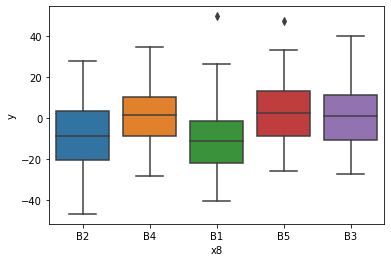

In [7]:
# x8
sb.boxplot(data=df9, x='x8', y='y')

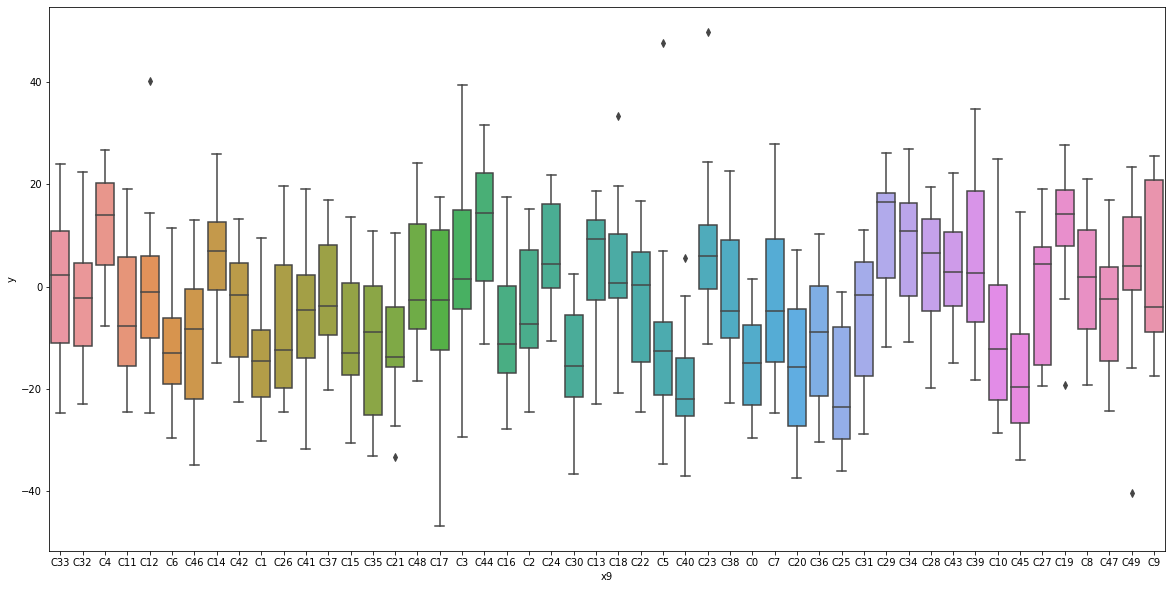

In [8]:
# x9
plt.figure(figsize=(20, 10))
sb.boxplot(data=df9, x='x9', y='y')

In [9]:
# Value counts for x9
df9['x9'].value_counts()

C5     32
C42    30
C10    28
C7     28
C41    26
C38    24
C39    24
C20    24
C23    23
C34    23
C48    23
C3     22
C4     22
C25    21
C35    21
C16    21
C22    21
C11    21
C17    21
C28    21
C44    21
C46    20
C15    20
C45    20
C33    20
C1     20
C37    20
C12    19
C30    19
C9     19
C19    18
C49    18
C29    18
C8     18
C47    18
C2     18
C32    18
C21    18
C13    17
C14    17
C6     17
C26    16
C31    16
C43    16
C40    15
C0     15
C36    14
C24    14
C27    13
C18    12
Name: x9, dtype: int64

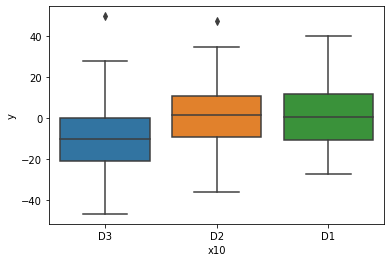

In [10]:
# x10
sb.boxplot(data=df9, x='x10', y='y')

In [11]:
# Any null
df9.isnull().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
y      0
dtype: int64

Notes:

- Some variability across all variables.
- Numerics:
    - None seem to obviously have a relationship with y
    - x3 and x6 seem highly correlated
    - x5 seems to have a different distribution than the others because it's outliers don't seem as randomly distributed as the others
- Categoricals:
    - x7/x8/x10 all seem to have some relationship with y
    - x9 has moderate cardinality (~50 values relative to the number of rows, 1k), which means we'll need to be a little careful in modelling it.  It seems at related to y, but hard to tell how well it will generalize with some of the low sample sizes.
- No missing values (at least as far as we can tell so far)

### Let's fit a quick kitchen sink model to start, including everything (even x9)

- Max depth of 1
- Require 2.5% of the data in each leaf

In [12]:
# Get matrices
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x9', 'x10']), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

         x1        x2        x3        x4        x5        x6  x7_A1  x7_A2  \
0 -1.912877 -0.509738  1.935923 -2.119992  0.474137  3.647543      0      1   
1 -0.341252  0.341502  2.268666 -0.948835 -0.492523  4.159113      1      0   
2  0.658157 -0.347933  3.104409  0.236928  0.359240  6.498557      1      0   
3  2.288540 -1.028834  3.554489 -0.215137 -0.436760  7.154874      0      1   
4  0.618358 -1.526877  3.857197 -0.343902  0.098206  7.857794      0      1   

   x8_B1  x8_B2  ...  x9_C48  x9_C49  x9_C5  x9_C6  x9_C7  x9_C8  x9_C9  \
0      0      1  ...       0       0      0      0      0      0      0   
1      0      0  ...       0       0      0      0      0      0      0   
2      0      0  ...       0       0      0      0      0      0      0   
3      1      0  ...       0       0      0      0      0      0      0   
4      0      1  ...       0       0      0      0      0      0      0   

   x10_D1  x10_D2  x10_D3  
0       0       0       1  
1       0       1 

In [13]:
# Fit tree
t9 = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=25,
    random_state=666
).fit(X, y)

[Text(1603.0044642857142, 764.4375, 'x7_A2 <= 0.5\nmse = 229.524\nsamples = 1000\nvalue = -3.109'),
 Text(904.2589285714286, 662.5125, 'x10_D3 <= 0.5\nmse = 128.352\nsamples = 508\nvalue = 6.71'),
 Text(493.23214285714283, 560.5875, 'x5 <= 1.439\nmse = 90.008\nsamples = 321\nvalue = 10.521'),
 Text(420.1607142857143, 458.66249999999997, 'x5 <= -0.338\nmse = 79.271\nsamples = 295\nvalue = 9.705'),
 Text(146.14285714285714, 356.7375, 'x2 <= -0.335\nmse = 76.976\nsamples = 122\nvalue = 13.019'),
 Text(73.07142857142857, 254.8125, 'mse = 74.603\nsamples = 46\nvalue = 9.882'),
 Text(219.21428571428572, 254.8125, 'x1 <= 0.199\nmse = 68.854\nsamples = 76\nvalue = 14.917'),
 Text(146.14285714285714, 152.88750000000005, 'mse = 62.357\nsamples = 40\nvalue = 17.007'),
 Text(292.2857142857143, 152.88750000000005, 'mse = 65.826\nsamples = 36\nvalue = 12.595'),
 Text(694.1785714285714, 356.7375, 'x4 <= -0.567\nmse = 67.686\nsamples = 173\nvalue = 7.368'),
 Text(511.5, 254.8125, 'x1 <= 0.121\nmse = 8

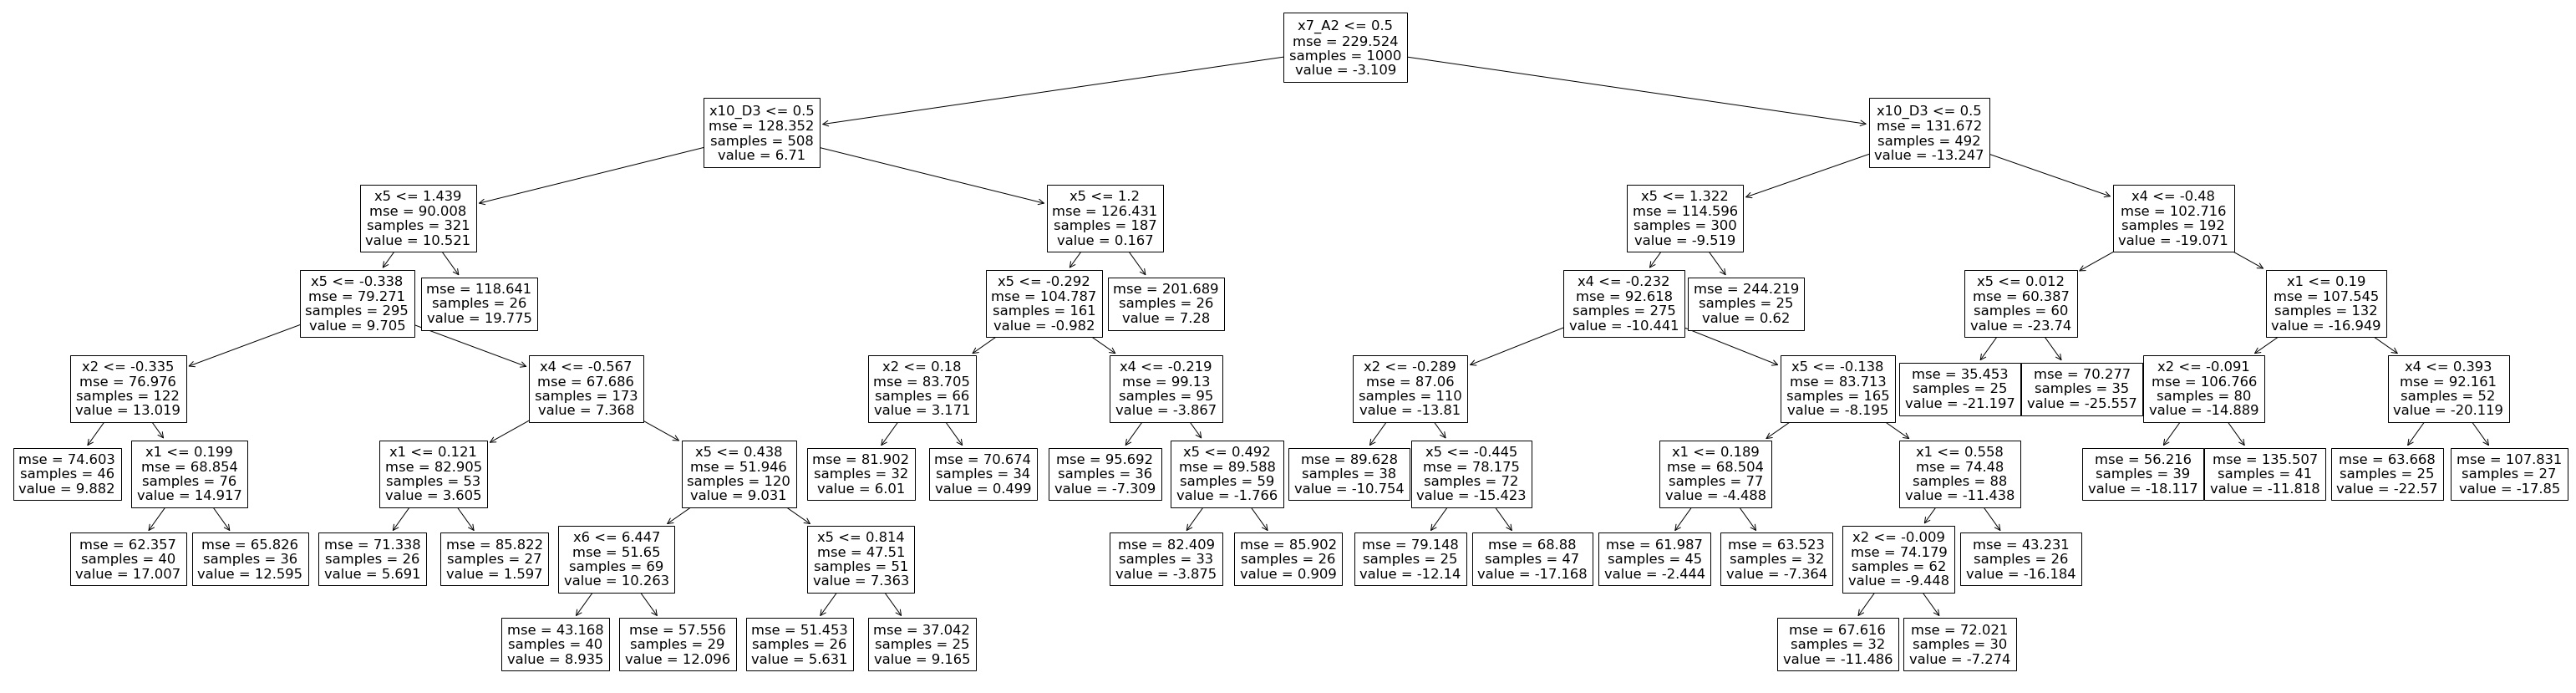

In [14]:
# Look at the tree
plt.figure(figsize=(55, 15))
plot_tree(t9, feature_names=X.columns)

Notes:

- First two splits are on categorical variables (x7 and x10, respectively) with high sample sizes for those values (~1:1 and ~3:2 splits, respectively)
- The next round of splits focus on x5, first towards higher x5 values and then values around 0
- The rest of other splits are scattered between the remaining numerical predictors (besides x3)

Let's see how the partial dependency plots look

C:\Users\Kenneth\Miniconda3\envs\d_anaconda\lib\site-packages\sklearn\tree\_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
C:\Users\Kenneth\Miniconda3\envs\d_anaconda\lib\site-packages\sklearn\inspection\_partial_dependence.py:713: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  warnings.warn("The fig parameter is deprecated in version "


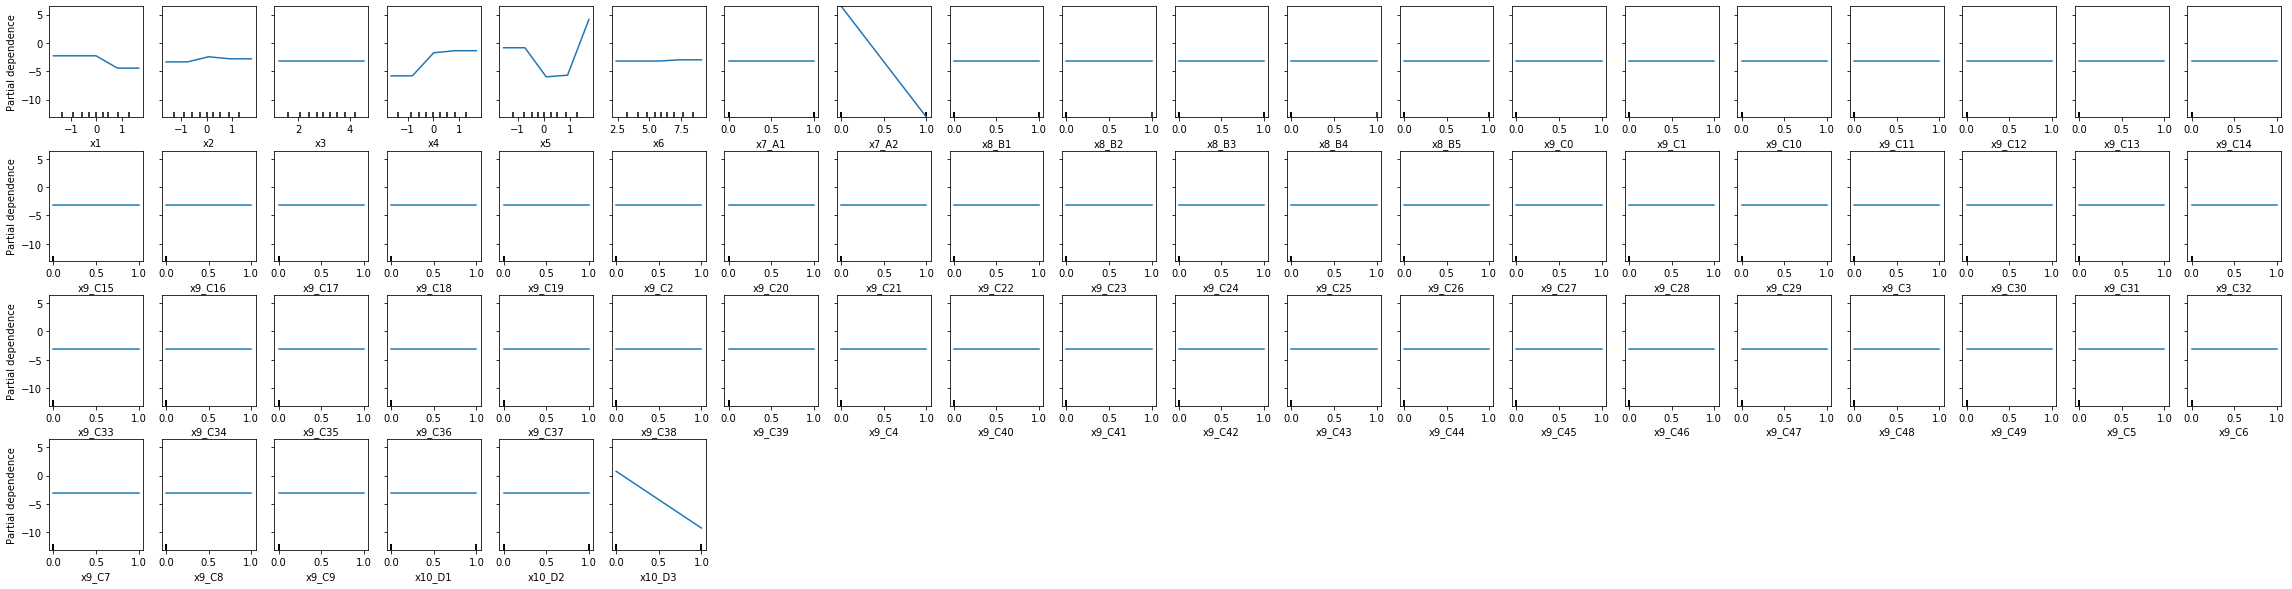

In [15]:
fig = plt.figure(figsize=(40, 10))
plot_partial_dependence(
    t9,
    X,
    X.columns,
    n_cols=20,
    grid_resolution=5,
    fig=fig
)
fig.subplots_adjust(hspace=0.3)

Looks in line with what we're seeing from the tree itself.

In [16]:
def plot_univariate(df, X, x, y, model_fit, n_bins=10):
    # Add prediction
    df = df.assign(p = model_fit.predict(X))
    
    # If x is numeric, bin into 5 groups
    if df[x].dtype in (np.int64, np.float64):
        df[x] = pd.cut(df[x], n_bins).apply(str)
    
    # Aggregate
    df_agg = (
        df
        .groupby(x)
        .agg(
            n=(y, 'count'),
            y_mean=(y, 'mean'),
            y_sd=(y, 'std'),
            p_mean=('p', 'mean'),
            p_sd=('p', 'std'),
        )
        .reset_index()
    )
    
    print(df_agg)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    
    # First plot: Counts
    ax1.bar(x, 'n', data=df_agg)
    
    # Second plot: Average actuals and predicted
    #ax2.scatter(x, 'y_mean', data=df_agg, label='Actual', marker='.', color='green', linewidth=3)
    ax2.errorbar(x, 'y_mean', yerr='y_sd', data=df_agg, label='Actual', fmt='o', capsize=10, color='green')
    #ax2.scatter(x, 'p_mean', data=df_agg, label='Predicted', marker='.', color='red', linewidth=3)
    ax2.errorbar(x, 'p_mean', yerr='p_sd', data=df_agg, label='Predicted', fmt='o', capsize=10, color='red')
    
    plt.legend()
    plt.show()

                 x1    n     y_mean       y_sd     p_mean       p_sd
0  (-3.156, -2.508]    7  -6.313165  15.030758  -3.725371  14.250649
1  (-2.508, -1.867]   25  -6.906888  14.180164  -5.924423  11.500748
2  (-1.867, -1.225]   89  -5.867852  14.322453  -2.829914  11.653874
3  (-1.225, -0.584]  179  -0.568878  15.301959  -0.951899  11.792432
4  (-0.584, 0.0577]  234  -0.139050  15.038373  -2.270108  12.092816
5   (0.0577, 0.699]  238  -5.980640  15.042028  -4.996349  12.856866
6    (0.699, 1.341]  136  -2.863535  14.968506  -2.727743  12.339475
7    (1.341, 1.982]   77  -4.701234  15.187662  -4.228889  11.368621
8    (1.982, 2.624]   11  -1.328889  15.699184  -3.836011  12.513315
9    (2.624, 3.265]    4 -11.520226   8.920396 -13.356653   7.424798


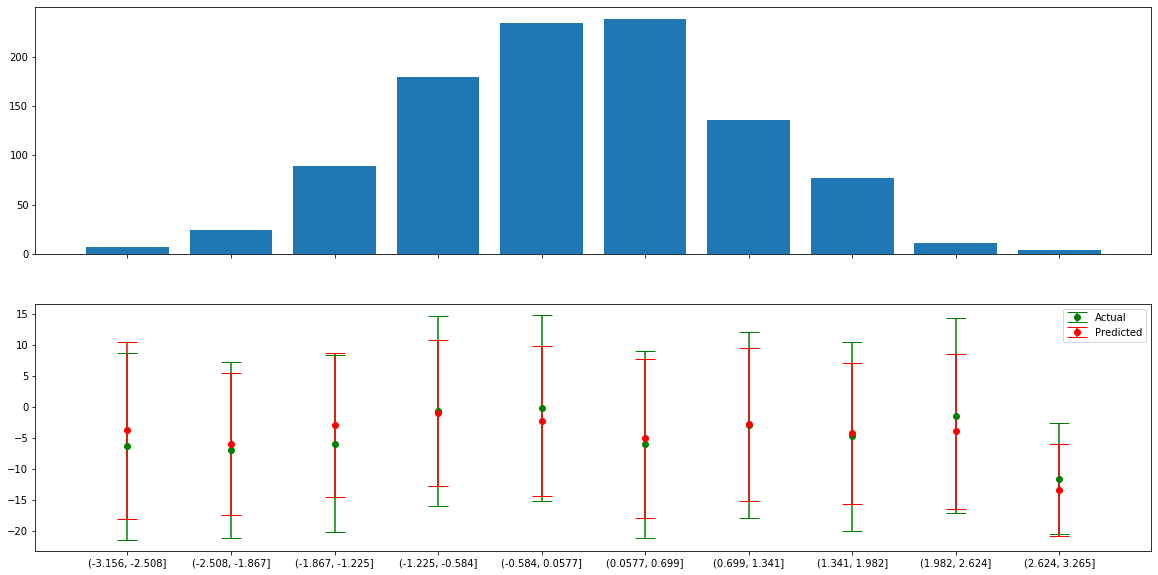

In [17]:
# x1
plot_univariate(df9, X, 'x1', 'y', t9)

                 x2    n    y_mean       y_sd    p_mean       p_sd
0  (-3.114, -2.394]    6 -8.036651  12.048253  2.281182  11.442672
1  (-2.394, -1.681]   33 -8.330209  12.432936 -6.320579  11.009229
2  (-1.681, -0.967]  142 -4.265981  13.981517 -4.949186  12.097893
3  (-0.967, -0.254]  228 -3.445199  15.719105 -3.629271  12.076462
4   (-0.254, 0.459]  273 -2.558462  15.349517 -2.860400  12.415479
5    (0.459, 1.172]  205 -2.208190  16.058501 -2.053152  12.637581
6    (1.172, 1.886]   72 -2.226685  14.414956 -2.361047  11.377388
7    (1.886, 2.599]   33 -0.980166  13.639297 -1.156531  12.438270
8    (2.599, 3.312]    5 -5.989441  12.153853  0.206591   6.817105
9    (3.312, 4.026]    3 -6.950856  14.290031  8.355572   3.335253


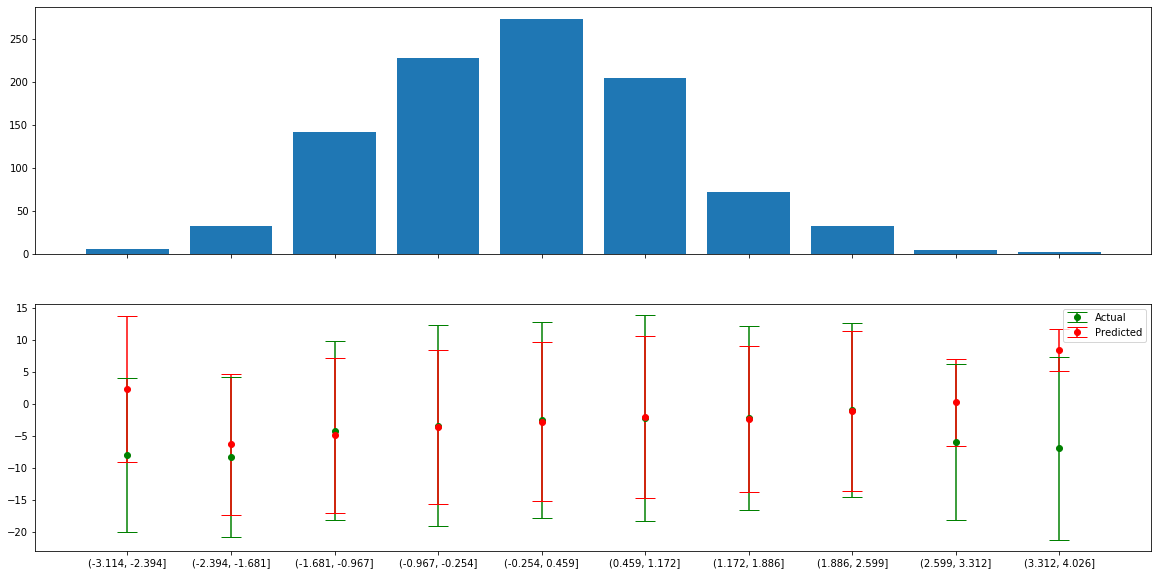

In [18]:
# x2
plot_univariate(df9, X, 'x2', 'y', t9)

                x3    n    y_mean       y_sd    p_mean       p_sd
0  (-0.298, 0.364]    8  3.606228  14.675116  1.827908  12.011664
1    (0.364, 1.02]   17 -8.370971  11.552303 -7.990854   9.896969
2    (1.02, 1.675]   82 -4.374112  15.526482 -3.353153  12.958079
3   (1.675, 2.331]  149 -1.796373  15.092307 -2.825328  12.742787
4   (2.331, 2.986]  251 -4.587268  14.915665 -3.982586  12.030832
5   (2.986, 3.642]  235 -2.146294  15.531851 -2.498062  12.085199
6   (3.642, 4.298]  172 -3.448702  14.912676 -3.521535  11.881213
7   (4.298, 4.953]   63 -1.299861  15.500577 -1.043507  12.710416
8   (4.953, 5.609]   19 -2.600386  15.980956 -1.850484  11.752273
9   (5.609, 6.265]    4  2.763763  15.246697  0.358647  13.730075


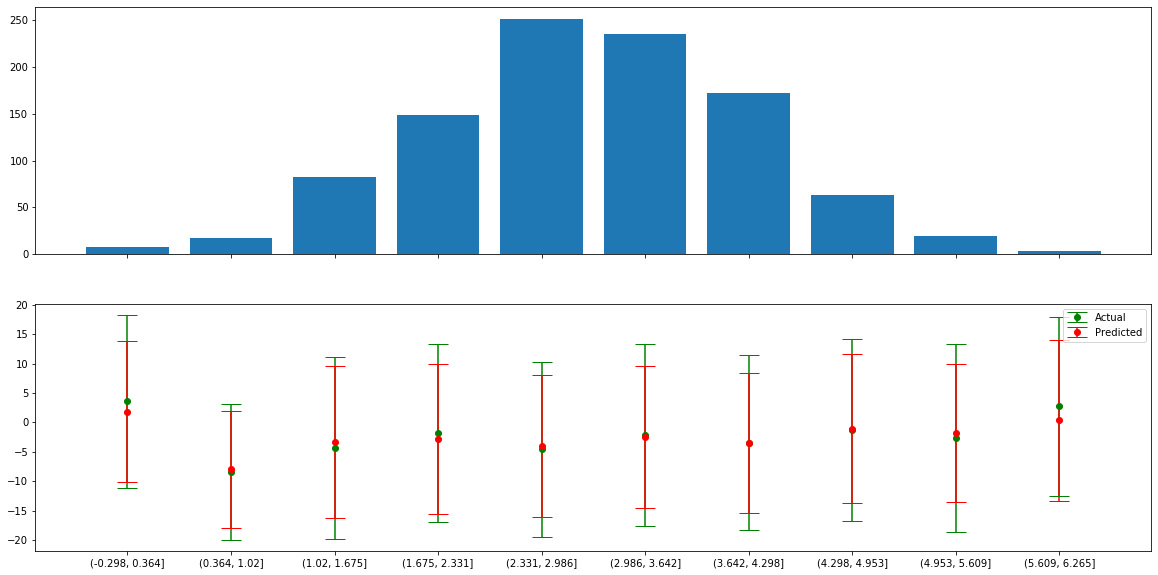

In [19]:
# x3
plot_univariate(df9, X, 'x3', 'y', t9)

                 x4    n     y_mean       y_sd     p_mean       p_sd
0  (-3.294, -2.595]    8 -10.219785  14.908367 -11.451390  13.365458
1  (-2.595, -1.904]   22  -6.542120  17.129693  -4.300831  14.177312
2  (-1.904, -1.213]   97  -3.782665  15.173689  -3.677844  12.803625
3  (-1.213, -0.521]  180  -6.451188  15.809415  -6.032420  13.372606
4    (-0.521, 0.17]  257  -1.539984  15.472959  -1.829340  12.643385
5     (0.17, 0.861]  237  -4.559496  14.172977  -3.245247  11.075484
6    (0.861, 1.553]  143   0.219736  15.019398  -0.859235  10.799649
7    (1.553, 2.244]   39   0.143603  11.568106  -3.176165  10.495414
8    (2.244, 2.935]   12   3.327154  11.342277   0.578309   9.283983
9    (2.935, 3.627]    5   8.849646  13.003119  -0.223114  13.714294


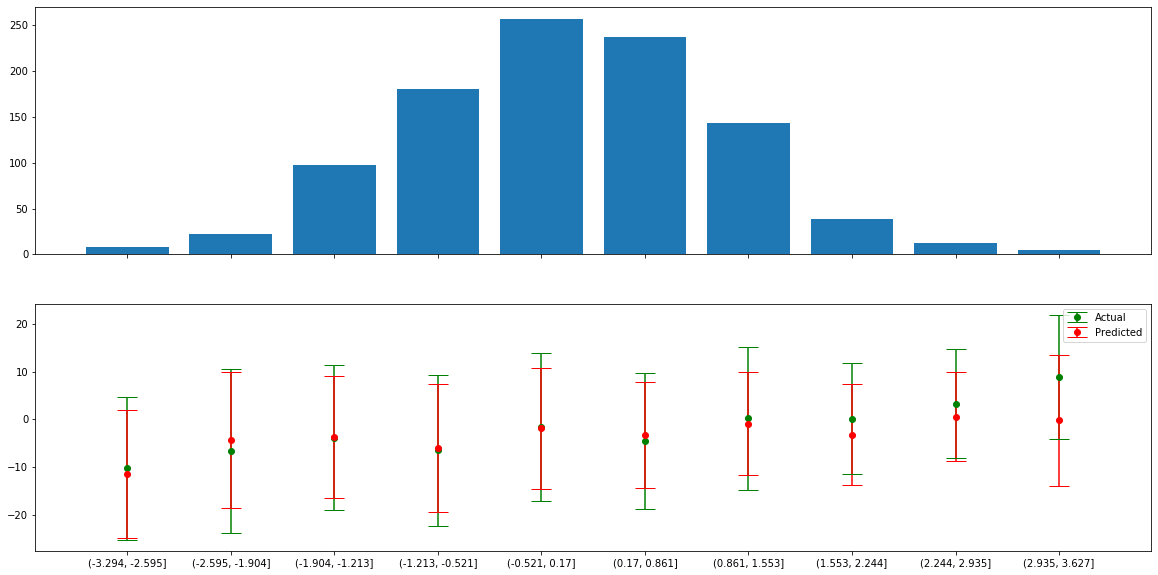

In [20]:
# x4
plot_univariate(df9, X, 'x4', 'y', t9)

                 x5    n     y_mean       y_sd     p_mean       p_sd
0  (-3.291, -2.678]    2 -43.630432   4.531699 -17.983381   0.188744
1  (-2.678, -2.071]    9 -10.075823  12.774264  -1.011356  13.417566
2  (-2.071, -1.464]   52   2.301504  15.530816  -0.116448  12.735665
3  (-1.464, -0.857]  111  -0.591558  12.315051  -1.084186  11.300320
4  (-0.857, -0.251]  212  -0.203367  14.372136  -0.470879  12.228398
5   (-0.251, 0.356]  244  -5.890977  13.968151  -6.009941  11.391644
6    (0.356, 0.963]  200  -7.907987  14.300837  -6.745028  10.487704
7     (0.963, 1.57]  107  -5.480283  14.574254  -2.207650  12.052459
8     (1.57, 2.177]   46   5.049507  14.550971   3.702143  16.254872
9    (2.177, 2.783]   17  25.361991  15.415730   2.567618  12.955670


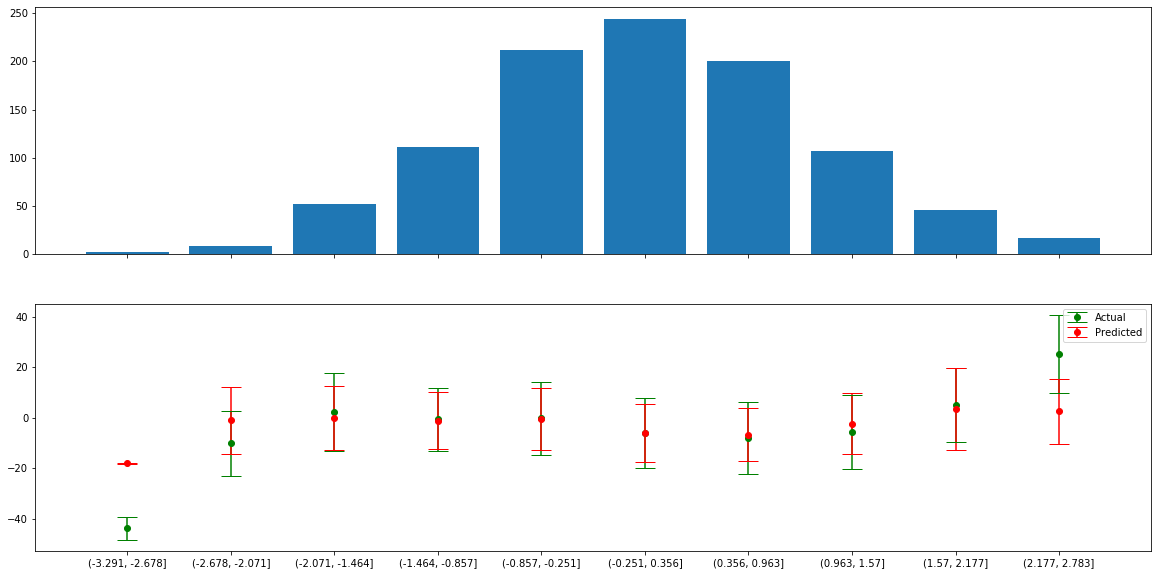

In [21]:
# x5
plot_univariate(df9, X, 'x5', 'y', t9)

                 x6    n    y_mean       y_sd    p_mean       p_sd
0   (-0.779, 0.601]    7  6.032471  14.011070  3.133114  12.346126
1    (0.601, 1.968]   17 -6.701305  11.019841 -7.164251   9.851399
2    (1.968, 3.334]   82 -4.892416  15.179086 -3.534761  12.784349
3    (3.334, 4.701]  168 -1.806620  15.186986 -2.977759  12.500817
4    (4.701, 6.068]  245 -4.811870  15.378084 -4.012963  12.324999
5    (6.068, 7.434]  249 -1.590667  15.008175 -1.857395  11.903365
6    (7.434, 8.801]  161 -3.835361  14.651628 -3.795880  11.865411
7   (8.801, 10.168]   52 -2.326140  16.530921 -2.532935  13.180131
8  (10.168, 11.534]   16 -1.220950  16.169758 -1.378635  11.289372
9  (11.534, 12.901]    3  0.120046  17.514485 -2.815904  14.909923


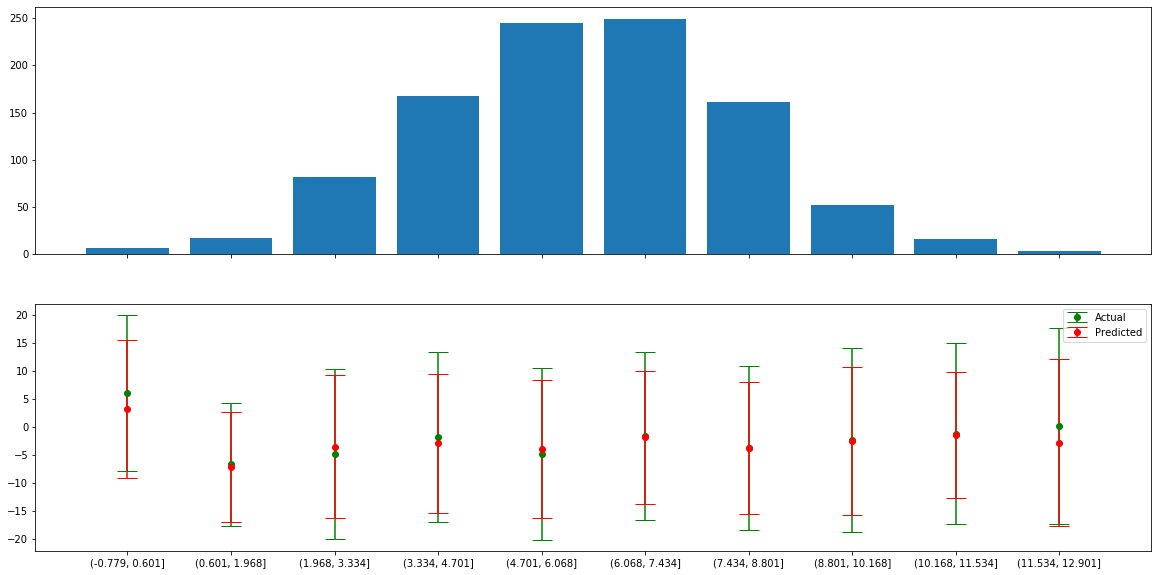

In [22]:
# x6
plot_univariate(df9, X, 'x6', 'y', t9)

   x7    n     y_mean       y_sd     p_mean      p_sd
0  A1  508   6.709537  11.340405   6.709537  7.067578
1  A2  492 -13.246832  11.486507 -13.246832  7.018632


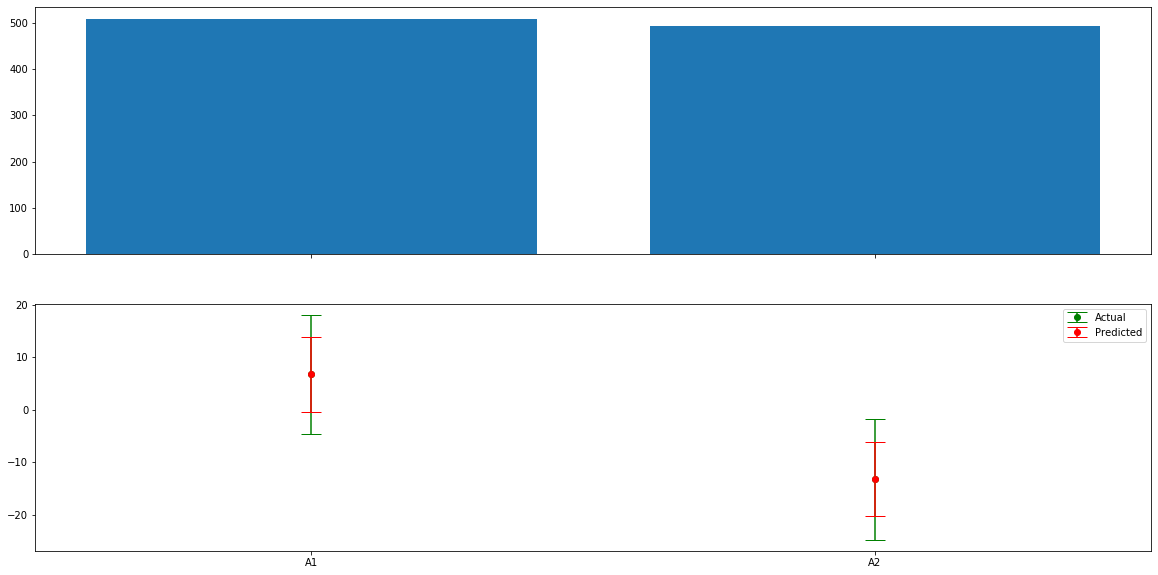

In [23]:
# x7
plot_univariate(df9, X, 'x7', 'y', t9)

   x8    n     y_mean       y_sd    p_mean       p_sd
0  B1  231 -10.670510  14.192590 -9.927246  10.765923
1  B2  170  -8.561023  14.859238 -8.193082  11.166622
2  B3  218   0.840592  14.367412  0.792288  11.689094
3  B4  170   0.955568  13.056131  0.464877  11.178250
4  B5  211   2.206488  14.116294  1.541578  10.990665


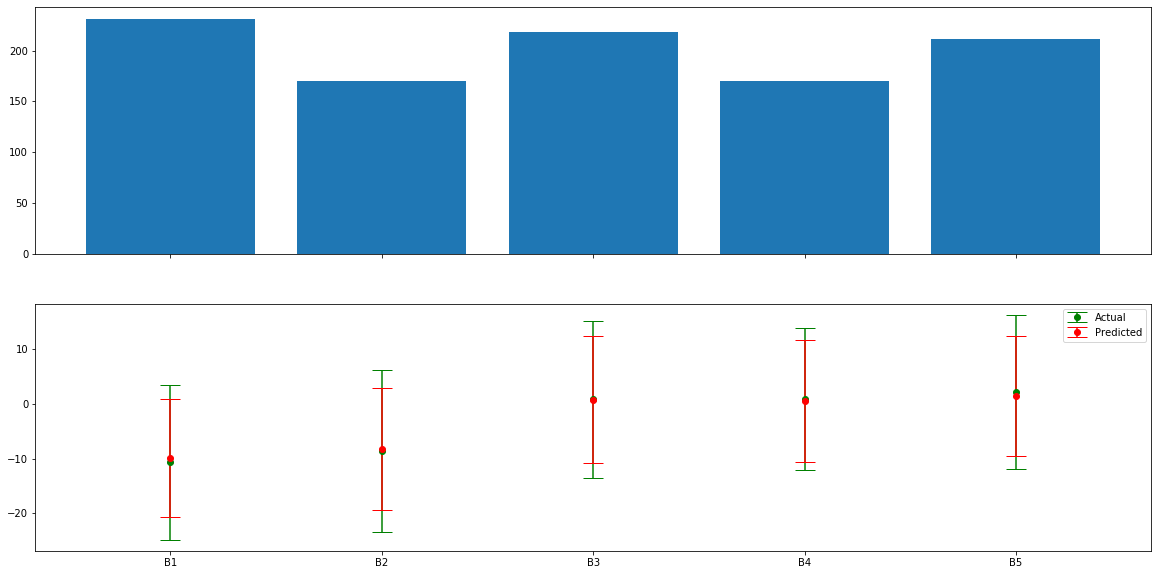

In [24]:
# x8
plot_univariate(df9, X, 'x8', 'y', t9)

     x9   n     y_mean       y_sd     p_mean       p_sd
0    C0  15 -14.964970  10.589358  -7.067703  10.255190
1    C1  20 -13.259830  11.731550  -5.932365  13.758699
2   C10  28 -10.318145  13.439793  -3.451521  12.612343
3   C11  21  -4.835676  13.653536  -0.561652  13.318490
4   C12  19  -1.179628  14.839631  -2.298437  12.637070
5   C13  17   3.900295  12.651150  -2.703017  12.641812
6   C14  17   5.196334  10.934525  -2.282633  12.018147
7   C15  20  -9.186914  12.671340  -2.600642  12.323213
8   C16  21  -8.366996  12.107585  -5.065039  11.880921
9   C17  21  -3.341562  16.038038  -2.295996  11.718121
10  C18  12   3.346333  14.467222  -5.246187  12.314927
11  C19  18  11.671869  11.388049   2.698628  11.642492
12   C2  18  -4.783132  12.484306  -1.487584  12.970745
13  C20  24 -15.938042  14.072403  -6.272101  12.891657
14  C21  18 -11.672869  11.694724  -6.070855  11.331427
15  C22  21  -2.830809  12.411048  -3.662563  13.719881
16  C23  23   7.584358  13.240892   1.288713  11

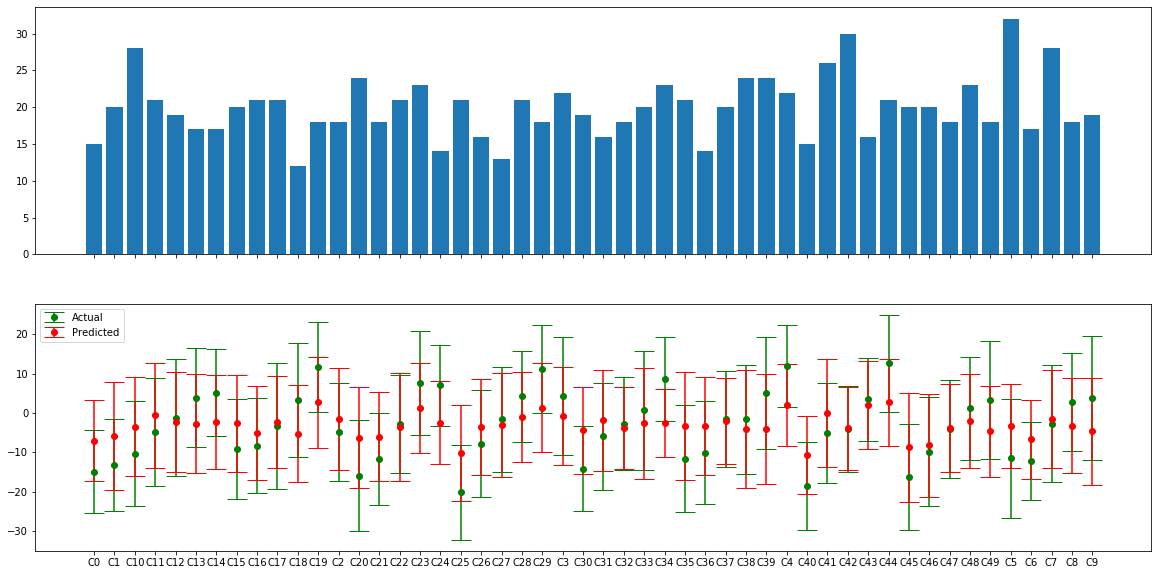

In [25]:
# x9
plot_univariate(df9, X, 'x9', 'y', t9)

  x10    n    y_mean       y_sd    p_mean       p_sd
0  D1  209  0.781634  14.500883  0.789677  11.672259
1  D2  412  0.869159  14.108635  0.865079  11.139501
2  D3  379 -9.579029  14.404048 -9.579029  10.808982


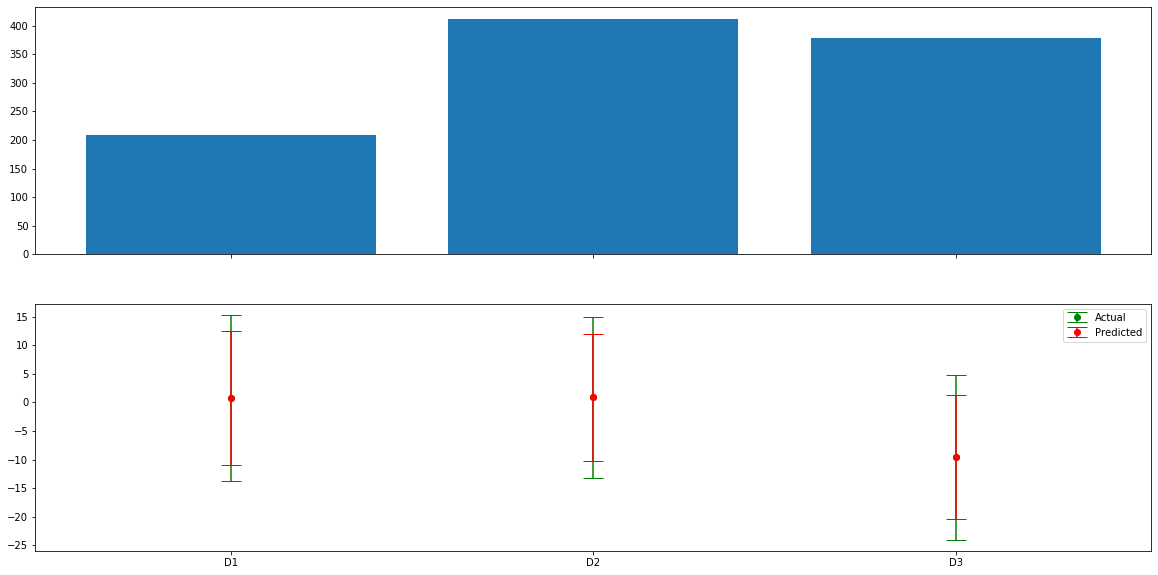

In [26]:
# x10
plot_univariate(df9, X, 'x10', 'y', t9)

Notes:

- x5, the cubic relationship, seems to fit fairly well except on the extremes (and generally we'd bad at the extremes of the numeric variables)
- Predicted means for categoricals except x9 are spot on
- x9 is a bit all over the place

### Let's try to better incorporate x9 into the numeric using some type encodings.

For simplicity, let's just use the mean.

In [27]:
df9_x9means = df9.groupby('x9').agg(y_mean=('y', 'mean'))['y_mean'].to_dict()
df9['x9_mean'] = df9['x9'].map(df9_x9means)

# Inspect
df9

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y,x9_mean
0,-1.912877,-0.509738,1.935923,-2.119992,0.474137,3.647543,A2,B2,C33,D3,-23.858957,0.642088
1,-0.341252,0.341502,2.268666,-0.948835,-0.492523,4.159113,A1,B4,C32,D2,4.795576,-2.746557
2,0.658157,-0.347933,3.104409,0.236928,0.359240,6.498557,A1,B4,C4,D2,16.359090,11.929453
3,2.288540,-1.028834,3.554489,-0.215137,-0.436760,7.154874,A2,B1,C11,D3,-24.550723,-4.835676
4,0.618358,-1.526877,3.857197,-0.343902,0.098206,7.857794,A2,B2,C12,D3,-23.033020,-1.179628
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.377935,-0.810448,3.658649,0.614948,-1.292935,7.227878,A1,B1,C13,D3,14.729703,3.900295
996,0.968435,1.273159,3.449217,-0.073787,1.088958,6.701653,A1,B4,C42,D2,5.337900,-4.073470
997,0.919181,-1.518937,3.427333,1.152154,0.039267,6.797440,A2,B1,C22,D3,-8.781643,-2.830809
998,0.248702,-0.184816,2.923806,1.188720,-0.361918,6.040283,A2,B5,C11,D2,-15.494192,-4.835676


In [28]:
# Get matrices
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9_mean', 'x10']
X_x9mean, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']), df9['y']

# Inspect
print(X_x9mean[:5])
print()
print(y[:5])

         x1        x2        x3        x4        x5        x6    x9_mean  \
0 -1.912877 -0.509738  1.935923 -2.119992  0.474137  3.647543   0.642088   
1 -0.341252  0.341502  2.268666 -0.948835 -0.492523  4.159113  -2.746557   
2  0.658157 -0.347933  3.104409  0.236928  0.359240  6.498557  11.929453   
3  2.288540 -1.028834  3.554489 -0.215137 -0.436760  7.154874  -4.835676   
4  0.618358 -1.526877  3.857197 -0.343902  0.098206  7.857794  -1.179628   

   x7_A1  x7_A2  x8_B1  x8_B2  x8_B3  x8_B4  x8_B5  x10_D1  x10_D2  x10_D3  
0      0      1      0      1      0      0      0       0       0       1  
1      1      0      0      0      0      1      0       0       1       0  
2      1      0      0      0      0      1      0       0       1       0  
3      0      1      1      0      0      0      0       0       0       1  
4      0      1      0      1      0      0      0       0       0       1  

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name:

In [29]:
# Fit tree
t9_x9mean = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=25,
    random_state=666
).fit(X_x9mean, y)

[Text(1609.5570652173913, 764.4375, 'x7_A1 <= 0.5\nmse = 229.524\nsamples = 1000\nvalue = -3.109'),
 Text(900.6847826086956, 662.5125, 'x9_mean <= -4.43\nmse = 131.672\nsamples = 492\nvalue = -13.247'),
 Text(500.3804347826087, 560.5875, 'x10_D3 <= 0.5\nmse = 73.491\nsamples = 218\nvalue = -20.379'),
 Text(266.8695652173913, 458.66249999999997, 'x4 <= -0.227\nmse = 54.863\nsamples = 133\nvalue = -17.239'),
 Text(133.43478260869566, 356.7375, 'x9_mean <= -12.779\nmse = 32.123\nsamples = 59\nvalue = -20.696'),
 Text(66.71739130434783, 254.8125, 'mse = 23.787\nsamples = 25\nvalue = -22.736'),
 Text(200.1521739130435, 254.8125, 'mse = 32.944\nsamples = 34\nvalue = -19.197'),
 Text(400.304347826087, 356.7375, 'x5 <= 0.062\nmse = 55.866\nsamples = 74\nvalue = -14.482'),
 Text(333.5869565217391, 254.8125, 'mse = 34.281\nsamples = 38\nvalue = -11.207'),
 Text(467.0217391304348, 254.8125, 'mse = 55.367\nsamples = 36\nvalue = -17.94'),
 Text(733.8913043478261, 458.66249999999997, 'x9_mean <= -9.

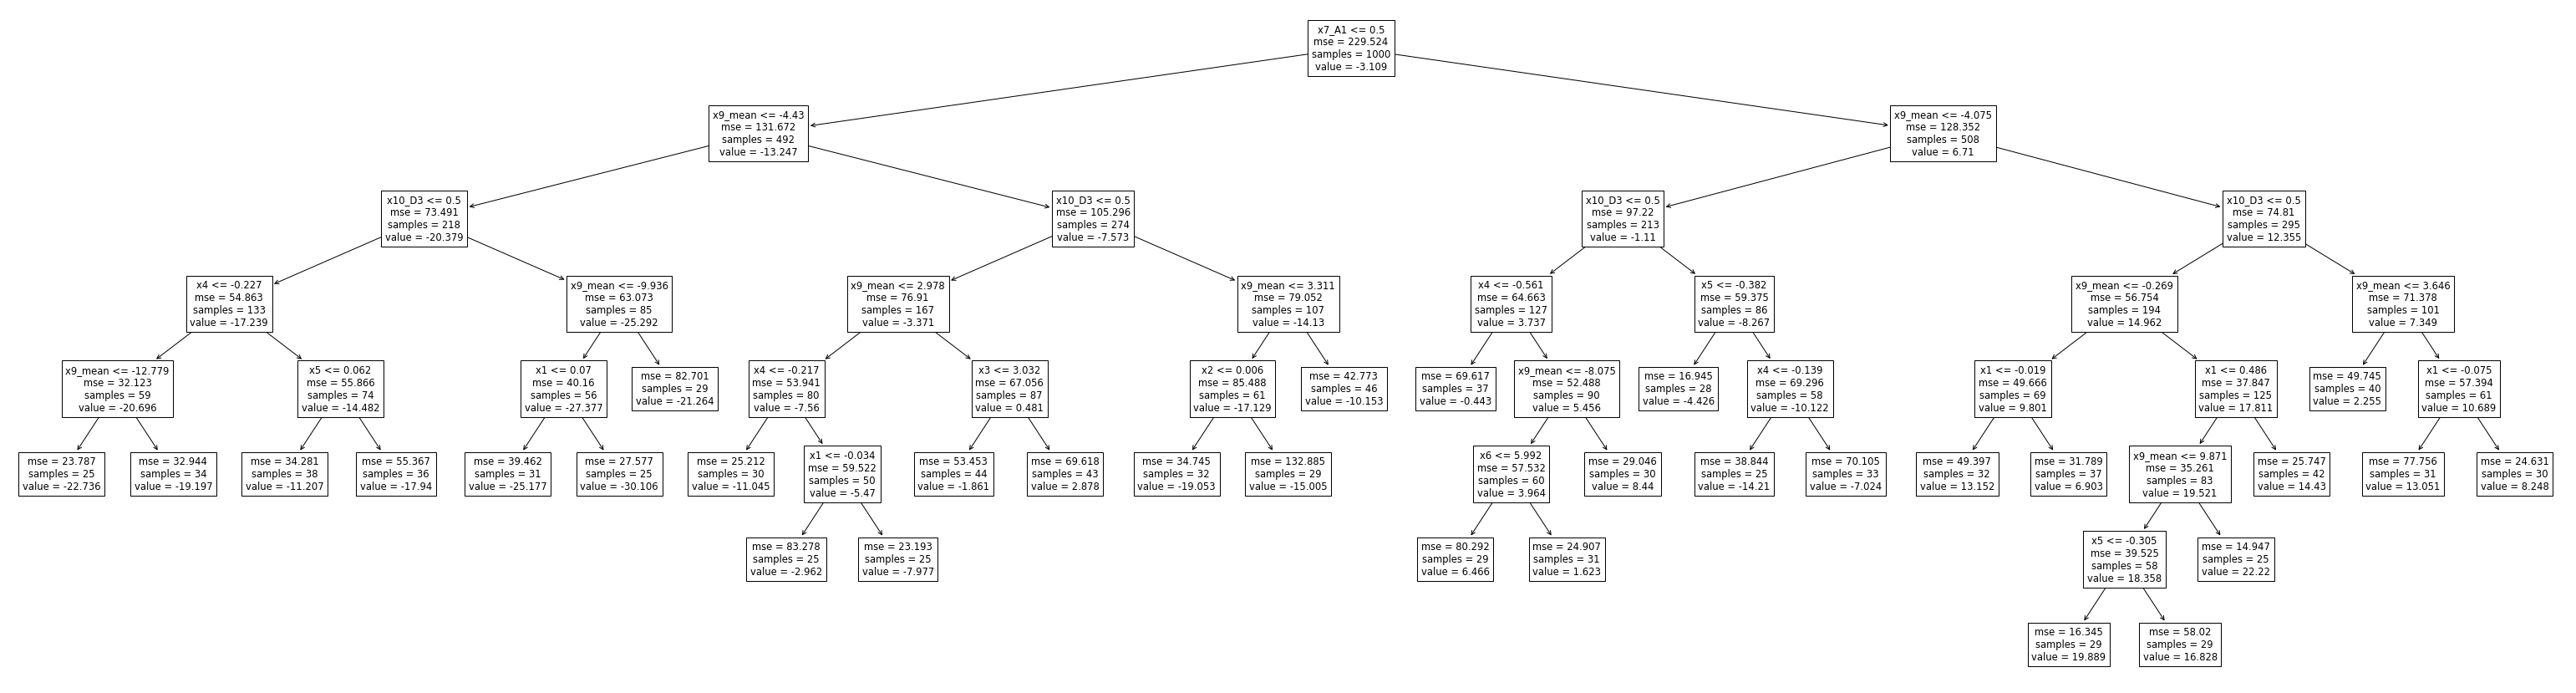

In [30]:
# Look at the tree
plt.figure(figsize=(55, 15))
plot_tree(t9_x9mean, feature_names=X_x9mean.columns)

We're splitting on x9_mean, and quite early on!  We also don't see nearly as many splits on x5 as we used to.

Let's look at the new univariates for both x9 and x9_mean

     x9   n     y_mean       y_sd     p_mean       p_sd
0    C0  15 -14.964970  10.589358 -15.333038  10.897005
1    C1  20 -13.259830  11.731550 -15.540297  11.589394
2   C10  28 -10.318145  13.439793  -9.152246  12.555260
3   C11  21  -4.835676  13.653536  -4.001789  12.470789
4   C12  19  -1.179628  14.839631  -0.973025  11.380736
5   C13  17   3.900295  12.651150   3.965750  11.504558
6   C14  17   5.196334  10.934525   5.254799  10.334290
7   C15  20  -9.186914  12.671340  -9.615934  10.534886
8   C16  21  -8.366996  12.107585  -9.221544  10.113106
9   C17  21  -3.341562  16.038038  -0.022542  11.096075
10  C18  12   3.346333  14.467222   0.763658   9.275286
11  C19  18  11.671869  11.388049  10.839178   9.570231
12   C2  18  -4.783132  12.484306  -9.830857  10.353005
13  C20  24 -15.938042  14.072403 -14.441087  11.660905
14  C21  18 -11.672869  11.694724 -13.810519  10.947255
15  C22  21  -2.830809  12.411048  -4.525170  11.981589
16  C23  23   7.584358  13.240892   8.673982   8

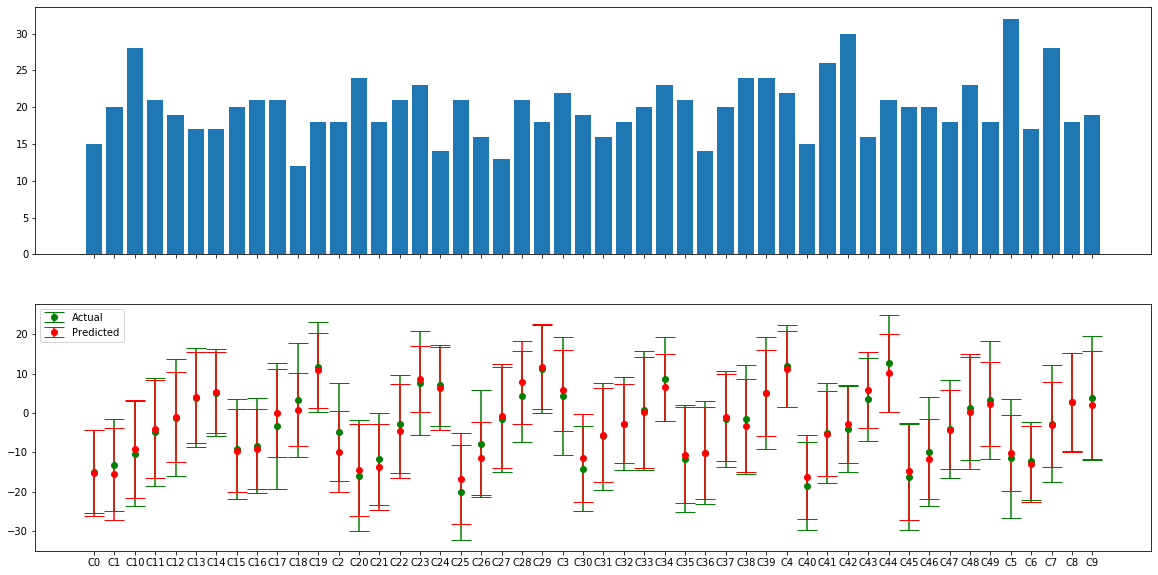

In [31]:
# x9
plot_univariate(df9, X_x9mean, 'x9', 'y', t9_x9mean)

              x9_mean    n     y_mean       y_sd     p_mean       p_sd
0  (-20.235, -16.924]   36 -19.507451  11.515760 -16.517258  11.034901
1  (-16.924, -13.645]   78 -15.417603  12.359928 -13.977287  11.463282
2  (-13.645, -10.366]  108 -12.012838  12.721910 -12.294639  10.779906
3   (-10.366, -7.087]  119  -9.326775  12.882948 -10.098294  10.721544
4    (-7.087, -3.809]  129  -4.741701  12.284858  -5.039768  10.871564
5     (-3.809, -0.53]  164  -2.239092  13.553269  -2.172856  11.206398
6      (-0.53, 2.749]   61   1.454723  13.405959   0.963745  13.651606
7      (2.749, 6.028]  166   4.131124  13.198452   4.511064  10.837726
8      (6.028, 9.306]   60   7.820868  11.482172   7.282060   8.880545
9     (9.306, 12.585]   79  11.876593  11.119464  10.978489   9.776560


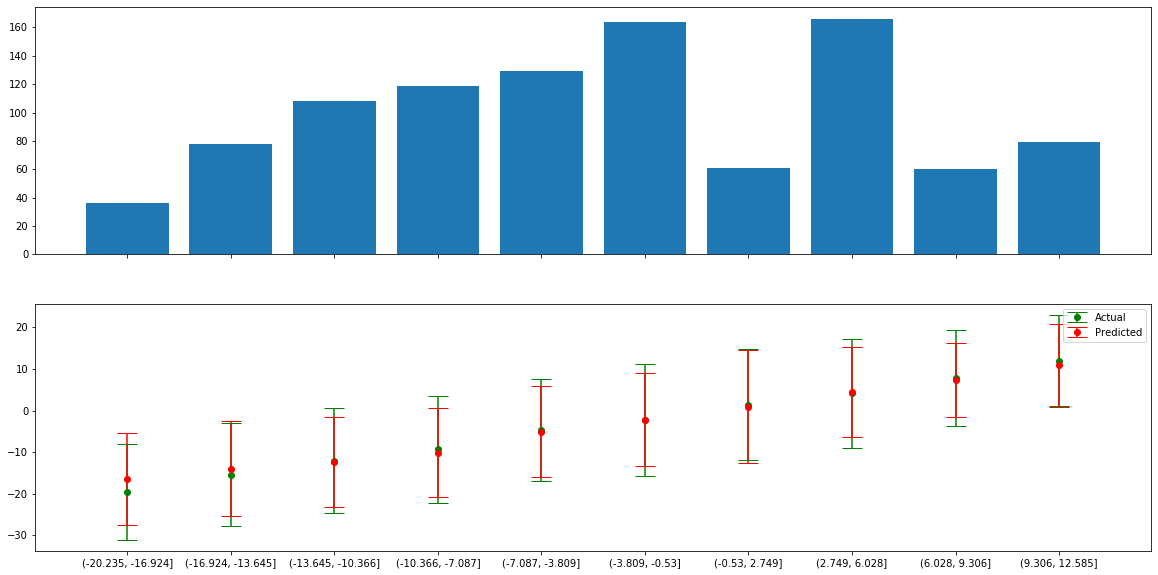

In [32]:
# x9_mean
plot_univariate(df9, X_x9mean, 'x9_mean', 'y', t9_x9mean)

Both look like much better fits than the previous model.

Let's look at the partial dependency plots as well.

C:\Users\Kenneth\Miniconda3\envs\d_anaconda\lib\site-packages\sklearn\tree\_classes.py:1233: FutureWarning: the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
  warnings.warn(msg, FutureWarning)
C:\Users\Kenneth\Miniconda3\envs\d_anaconda\lib\site-packages\sklearn\inspection\_partial_dependence.py:713: FutureWarning: The fig parameter is deprecated in version 0.22 and will be removed in version 0.24
  warnings.warn("The fig parameter is deprecated in version "


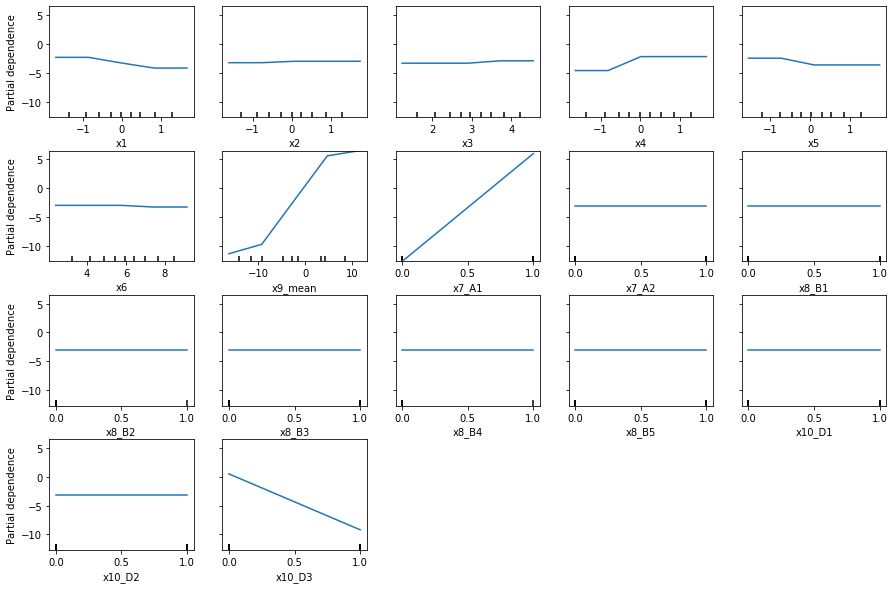

In [33]:
fig = plt.figure(figsize=(15, 10))
plot_partial_dependence(
    t9_x9mean,
    X_x9mean,
    X_x9mean.columns,
    n_cols=5,
    grid_resolution=5,
    fig=fig
)
fig.subplots_adjust(hspace=0.3)

It looks like we aren't picking up several things that we previously found to be predictive, like:

- The inverse parabolic structure with x7 of x2
- The linear relationship of x4
- The cubic nature of x5

Let's compare the error distributions of this model with the previous one.

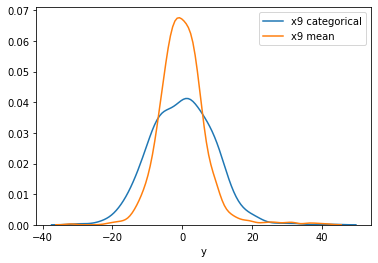

In [34]:
sb.distplot(y - t9.predict(X), hist=False, label='x9 categorical')
sb.distplot(y - t9_x9mean.predict(X_x9mean), hist=False, label='x9 mean')

The new model definitely looks like a better fit (e.g. more density close to zero).

### If we used just x2 and x7, can the tree pick up on the "circle" type pattern that we saw previously?

In [35]:
# Get matrices
predictors = ['x2', 'x7']
X_x2x7, y = pd.get_dummies(df9[predictors], prefix=['x7']), df9['y']

# Inspect
print(X_x2x7[:5])
print()
print(y[:5])

         x2  x7_A1  x7_A2
0 -0.509738      0      1
1  0.341502      1      0
2 -0.347933      1      0
3 -1.028834      0      1
4 -1.526877      0      1

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [36]:
# Fit tree
t9_x2x7 = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=25,
    random_state=666
).fit(X_x2x7, y)

[Text(1337.6398026315787, 774.63, 'x7_A1 <= 0.5\nmse = 229.524\nsamples = 1000\nvalue = -3.109'),
 Text(474.4835526315789, 693.09, 'x2 <= 1.495\nmse = 131.672\nsamples = 492\nvalue = -13.247'),
 Text(393.7203947368421, 611.55, 'x2 <= -1.148\nmse = 125.37\nsamples = 460\nvalue = -13.813'),
 Text(161.52631578947367, 530.01, 'x2 <= -1.42\nmse = 101.41\nsamples = 68\nvalue = -11.751'),
 Text(80.76315789473684, 448.47, 'mse = 96.004\nsamples = 41\nvalue = -11.325'),
 Text(242.28947368421052, 448.47, 'mse = 108.925\nsamples = 27\nvalue = -12.398'),
 Text(625.9144736842105, 530.01, 'x2 <= -0.386\nmse = 128.661\nsamples = 392\nvalue = -14.171'),
 Text(403.81578947368416, 448.47, 'x2 <= -0.563\nmse = 104.904\nsamples = 109\nvalue = -15.634'),
 Text(323.05263157894734, 366.93, 'x2 <= -0.961\nmse = 98.04\nsamples = 79\nvalue = -14.828'),
 Text(242.28947368421052, 285.39, 'mse = 131.42\nsamples = 27\nvalue = -16.279'),
 Text(403.81578947368416, 285.39, 'x2 <= -0.746\nmse = 79.047\nsamples = 52\nva

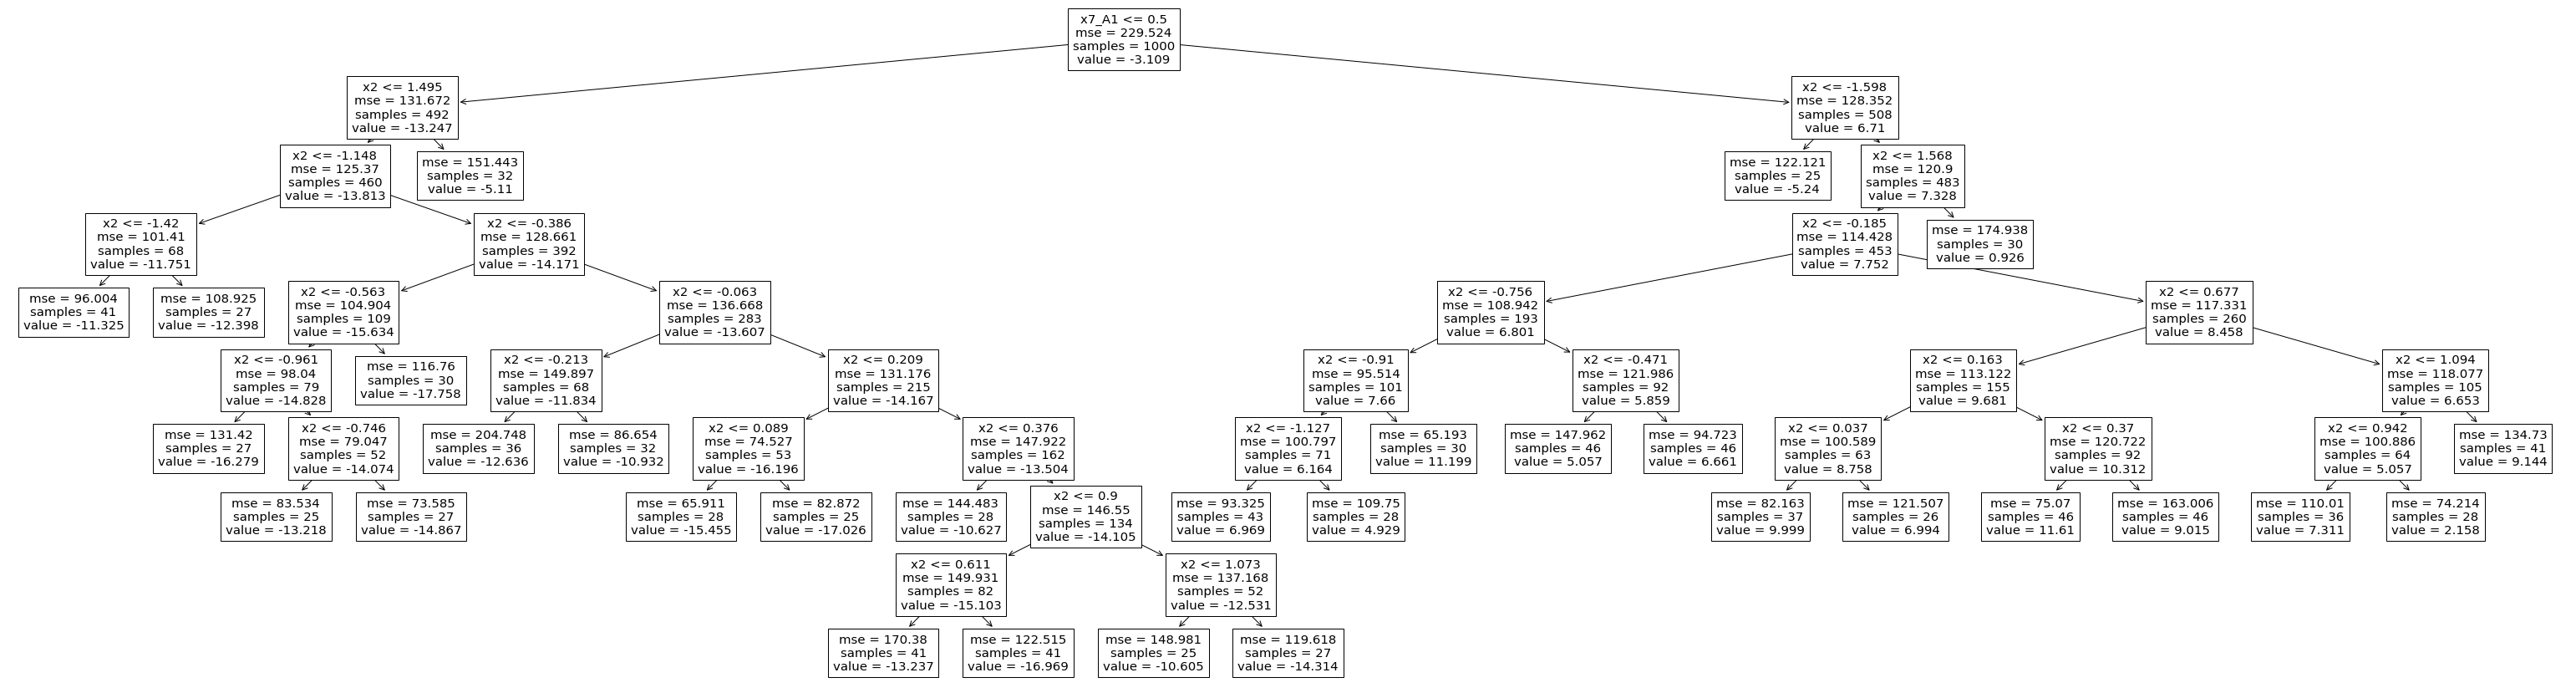

In [37]:
# Look at the tree
plt.figure(figsize=(55, 15))
plot_tree(t9_x2x7, feature_names=X_x2x7.columns)

Lot's of splitting but hard to make sense of what's going on.  Let's do the mesh-type plot that we've done before.

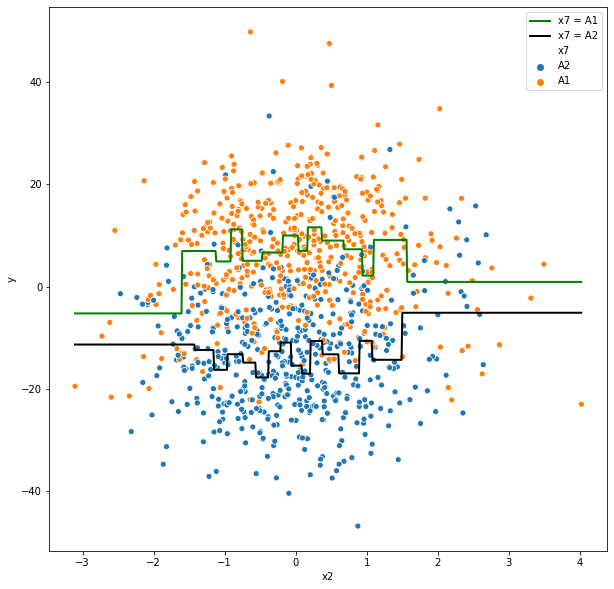

In [38]:
# Visualize
def create_x_mesh(x7_val):
    return pd.DataFrame({
        'x2': np.arange(df9['x2'].min(), df9['x2'].max(), .01),
        'x7_A1': 1 if x7_val == 'A1' else 0,
        'x7_A2': 1 if x7_val == 'A2' else 0,
    })

x_x2x7 = create_x_mesh('A1')['x2']
y_x2x7_A1 = t9_x2x7.predict(create_x_mesh('A1'))
y_x2x7_A2 = t9_x2x7.predict(create_x_mesh('A2'))

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x2', y='y', hue='x7')
sb.lineplot(x_x2x7, y_x2x7_A1, color='green', linewidth=2, label='x7 = A1')
sb.lineplot(x_x2x7, y_x2x7_A2, color='black', linewidth=2, label='x7 = A2')
plt.legend()
plt.show()

Eh, it kind of picks up on it but seems to be overfitting a bit in portions of middle.

Is there anything we can do to make it fit better?

Of course!

Remember that trees love to approximate monotonic relationships (i.e. trends in a consistent direction).  There a few ways we could transform a parabolic relationship into a linear one, with one being transforming x into the absolute value of the distance of x from the vertex of the parabola.  In math terms:

`x_new = abs(x - x_vertex)`

Let's be a tad hand-wavey and say that we feel good about the vertex being x=0, which simplifes the equation to:

`x_new = abs(x)`

We'll also track the *sign* of x2, which takes a value of -1 if the original x2 < 0 and 1 if the original x2 >= 0 to control for any potential asymmetry in the relationship of x2 and y.

In [39]:
df9['x2_abs'] = abs(df9['x2'])
df9['x2_sign'] = np.sign(df9['x2'])  # This technically returns 0 if x2 = 0, but let's say we're fine with that.

# Inspect
df9

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y,x9_mean,x2_abs,x2_sign
0,-1.912877,-0.509738,1.935923,-2.119992,0.474137,3.647543,A2,B2,C33,D3,-23.858957,0.642088,0.509738,-1.0
1,-0.341252,0.341502,2.268666,-0.948835,-0.492523,4.159113,A1,B4,C32,D2,4.795576,-2.746557,0.341502,1.0
2,0.658157,-0.347933,3.104409,0.236928,0.359240,6.498557,A1,B4,C4,D2,16.359090,11.929453,0.347933,-1.0
3,2.288540,-1.028834,3.554489,-0.215137,-0.436760,7.154874,A2,B1,C11,D3,-24.550723,-4.835676,1.028834,-1.0
4,0.618358,-1.526877,3.857197,-0.343902,0.098206,7.857794,A2,B2,C12,D3,-23.033020,-1.179628,1.526877,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.377935,-0.810448,3.658649,0.614948,-1.292935,7.227878,A1,B1,C13,D3,14.729703,3.900295,0.810448,-1.0
996,0.968435,1.273159,3.449217,-0.073787,1.088958,6.701653,A1,B4,C42,D2,5.337900,-4.073470,1.273159,1.0
997,0.919181,-1.518937,3.427333,1.152154,0.039267,6.797440,A2,B1,C22,D3,-8.781643,-2.830809,1.518937,-1.0
998,0.248702,-0.184816,2.923806,1.188720,-0.361918,6.040283,A2,B5,C11,D2,-15.494192,-4.835676,0.184816,-1.0


In [40]:
# Get matrices
predictors = ['x2_abs', 'x2_sign', 'x7']
X_x2x7_x2abs, y = pd.get_dummies(df9[predictors], prefix=['x7']), df9['y']

# Inspect
print(X_x2x7_x2abs[:5])
print()
print(y[:5])

     x2_abs  x2_sign  x7_A1  x7_A2
0  0.509738     -1.0      0      1
1  0.341502      1.0      1      0
2  0.347933     -1.0      1      0
3  1.028834     -1.0      0      1
4  1.526877     -1.0      0      1

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [41]:
# Fit tree
t9_x2x7_x2abs = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=25,
    random_state=666
).fit(X_x2x7_x2abs, y)

[Text(2038.0078125, 778.3363636363636, 'x7_A2 <= 0.5\nmse = 229.524\nsamples = 1000\nvalue = -3.109'),
 Text(1294.734375, 704.209090909091, 'x2_abs <= 2.038\nmse = 128.352\nsamples = 508\nvalue = 6.71'),
 Text(1198.828125, 630.0818181818181, 'x2_abs <= 0.942\nmse = 116.418\nsamples = 480\nvalue = 7.482'),
 Text(863.15625, 555.9545454545455, 'x2_abs <= 0.858\nmse = 112.965\nsamples = 318\nvalue = 8.381'),
 Text(767.25, 481.8272727272727, 'x2_abs <= 0.641\nmse = 114.517\nsamples = 288\nvalue = 7.993'),
 Text(479.53125, 407.7, 'x2_sign <= 0.0\nmse = 121.627\nsamples = 223\nvalue = 8.643'),
 Text(191.8125, 333.57272727272726, 'x2_abs <= 0.185\nmse = 115.589\nsamples = 104\nvalue = 7.412'),
 Text(95.90625, 259.4454545454545, 'mse = 82.541\nsamples = 31\nvalue = 8.814'),
 Text(287.71875, 259.4454545454545, 'x2_abs <= 0.448\nmse = 128.433\nsamples = 73\nvalue = 6.816'),
 Text(191.8125, 185.31818181818187, 'mse = 90.498\nsamples = 42\nvalue = 5.72'),
 Text(383.625, 185.31818181818187, 'mse = 1

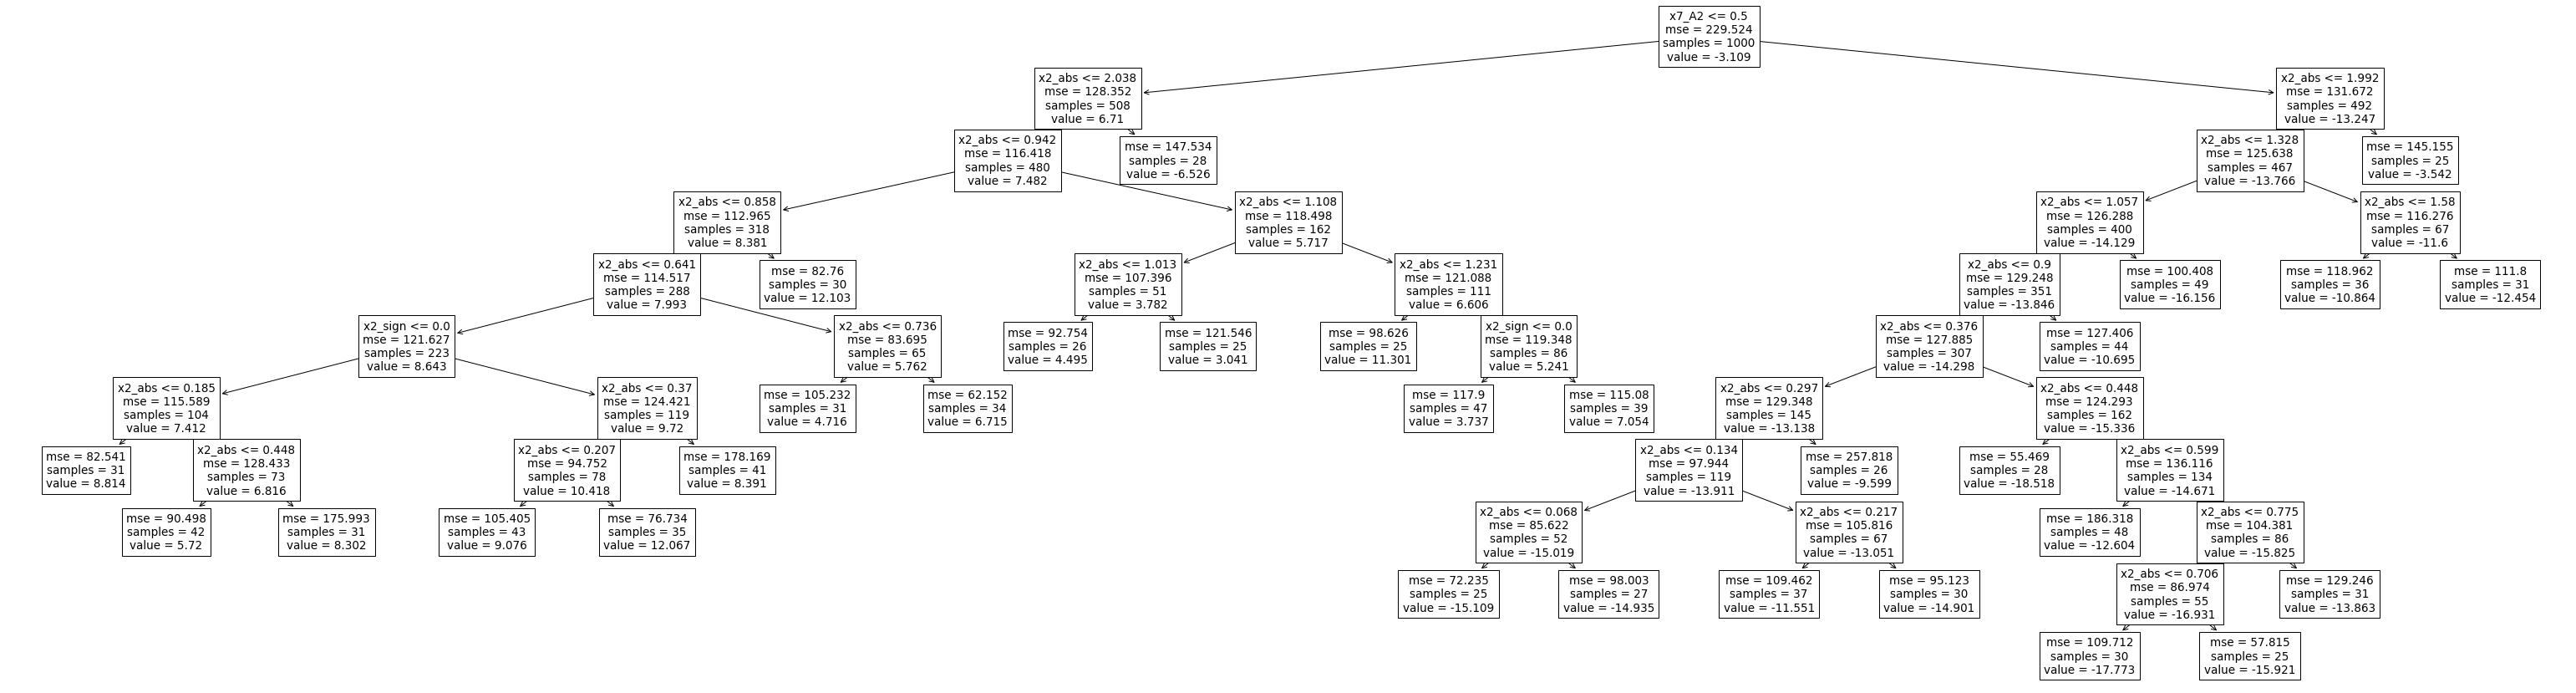

In [42]:
# Look at the tree
plt.figure(figsize=(55, 15))
plot_tree(t9_x2x7_x2abs, feature_names=X_x2x7_x2abs.columns)

Largely seem to be splpittig on the absolute value, but at least one split based on the sign.

Recreate the mesh-type plot.

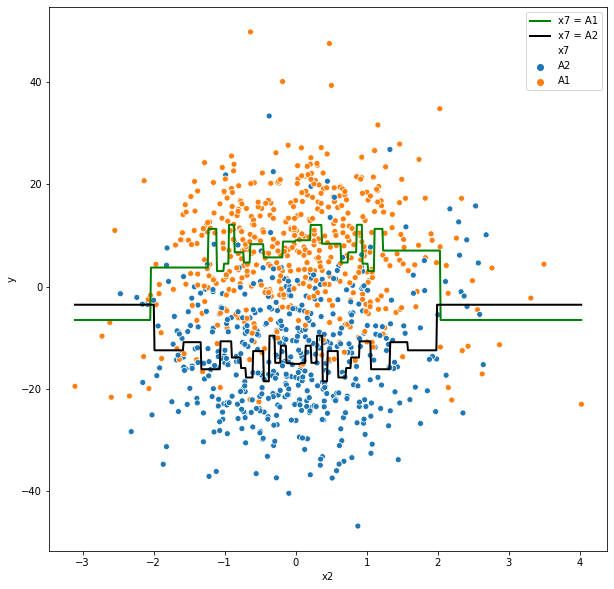

In [43]:
# Visualize
def create_x_mesh(x7_val):
    x = np.arange(df9['x2'].min(), df9['x2'].max(), .01)
    return pd.DataFrame({
        'x2_abs': abs(x),
        'x2_sign': np.sign(x),
        'x7_A1': 1 if x7_val == 'A1' else 0,
        'x7_A2': 1 if x7_val == 'A2' else 0,
    })

x_x2x7_x2abs = np.arange(df9['x2'].min(), df9['x2'].max(), .01)
y_x2x7_x2abs_A1 = t9_x2x7_x2abs.predict(create_x_mesh('A1'))
y_x2x7_x2abs_A2 = t9_x2x7_x2abs.predict(create_x_mesh('A2'))

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x2', y='y', hue='x7')
sb.lineplot(x_x2x7_x2abs, y_x2x7_x2abs_A1, color='green', linewidth=2, label='x7 = A1')
sb.lineplot(x_x2x7_x2abs, y_x2x7_x2abs_A2, color='black', linewidth=2, label='x7 = A2')
plt.legend()
plt.show()

Seems to do a generally better job, at least at the extremes.

Looking back at the tree, there are quite a few splits where we really don't see to be improving the overall fit very much.  Since the issue seems to be noise in the underlying data, one option is to increase the number of minimum number of sample points that we need in each leaf node.  Let's try bumping it up to 15%.

In [44]:
# Fit tree
t9_x2x7_x2abs_min150 = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=150,
    random_state=666
).fit(X_x2x7_x2abs, y)

[Text(310.0, 332.955, 'x7_A2 <= 0.5\nmse = 229.524\nsamples = 1000\nvalue = -3.109'),
 Text(186.0, 237.825, 'x2_abs <= 0.942\nmse = 128.352\nsamples = 508\nvalue = 6.71'),
 Text(124.0, 142.695, 'x2_sign <= 0.0\nmse = 112.965\nsamples = 318\nvalue = 8.381'),
 Text(62.0, 47.565, 'mse = 104.736\nsamples = 158\nvalue = 7.434'),
 Text(186.0, 47.565, 'mse = 119.331\nsamples = 160\nvalue = 9.316'),
 Text(248.0, 142.695, 'mse = 141.61\nsamples = 190\nvalue = 3.913'),
 Text(434.0, 237.825, 'x2_abs <= 0.9\nmse = 131.672\nsamples = 492\nvalue = -13.247'),
 Text(372.0, 142.695, 'x2_abs <= 0.386\nmse = 127.885\nsamples = 307\nvalue = -14.298'),
 Text(310.0, 47.565, 'mse = 128.518\nsamples = 151\nvalue = -13.329'),
 Text(434.0, 47.565, 'mse = 125.481\nsamples = 156\nvalue = -15.236'),
 Text(496.0, 142.695, 'mse = 133.08\nsamples = 185\nvalue = -11.503')]

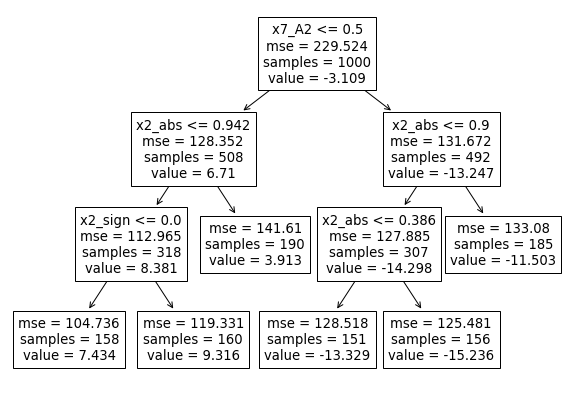

In [45]:
# Look at the tree
plt.figure(figsize=(10, 7))
plot_tree(t9_x2x7_x2abs_min150, feature_names=X_x2x7_x2abs.columns)

A much simpler model!

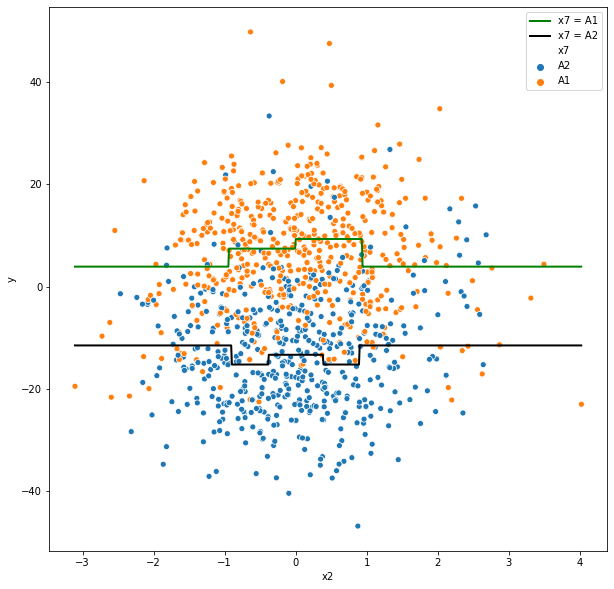

In [46]:
# Visualize
def create_x_mesh(x7_val):
    x = np.arange(df9['x2'].min(), df9['x2'].max(), .01)
    return pd.DataFrame({
        'x2_abs': abs(x),
        'x2_sign': np.sign(x),
        'x7_A1': 1 if x7_val == 'A1' else 0,
        'x7_A2': 1 if x7_val == 'A2' else 0,
    })

x_x2x7_x2abs = np.arange(df9['x2'].min(), df9['x2'].max(), .01)
y_x2x7_x2abs_A1 = t9_x2x7_x2abs_min150.predict(create_x_mesh('A1'))
y_x2x7_x2abs_A2 = t9_x2x7_x2abs_min150.predict(create_x_mesh('A2'))

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x2', y='y', hue='x7')
sb.lineplot(x_x2x7_x2abs, y_x2x7_x2abs_A1, color='green', linewidth=2, label='x7 = A1')
sb.lineplot(x_x2x7_x2abs, y_x2x7_x2abs_A2, color='black', linewidth=2, label='x7 = A2')
plt.legend()
plt.show()

Looks quite a bit more parabolic, at the expense of the fit not looking as good on the training data.  Train/test/holdout would help a lot in assessing whether it is actually a better or worse approach.  This is the last time we'll gloss over that topic.  :)